In [1]:
!pip install -q optuna scikit-learn matplotlib seaborn pandas

In [2]:
# Imports principais
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from itertools import combinations
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder

import optuna

Matplotlib is building the font cache; this may take a moment.


In [3]:
colunas = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label", "difficulty"
]


mapa_ataques = {
    'normal': 'normal',

    # DoS
    'neptune': 'dos', 'smurf': 'dos', 'back': 'dos', 'teardrop': 'dos', 'pod': 'dos',
    'land': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'mailbomb': 'dos', 'udpstorm': 'dos',

    # Probe
    'satan': 'probe', 'ipsweep': 'probe', 'portsweep': 'probe', 'nmap': 'probe',
    'mscan': 'probe', 'saint': 'probe',

    # R2L
    'warezclient': 'r2l', 'guess_passwd': 'r2l', 'warezmaster': 'r2l', 'imap': 'r2l',
    'ftp_write': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'spy': 'r2l',
    'named': 'r2l', 'sendmail': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l',
    'worm': 'r2l', 'snmpgetattack': 'r2l', 'snmpguess': 'r2l',

    # U2R
    'buffer_overflow': 'u2r', 'rootkit': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r',
    'httptunnel': 'u2r', 'ps': 'u2r', 'xterm': 'u2r', 'sqlattack': 'u2r'
}


df_train_full = pd.read_csv('KDDTrain.txt', names=colunas)
df_test_final = pd.read_csv('KDDTest.txt', names=colunas)


df_train_full.drop(columns=['difficulty'], inplace=True)
df_test_final.drop(columns=['difficulty'], inplace=True)

# Aplica mapeamento
df_train_full['label'] = df_train_full['label'].map(mapa_ataques)
df_test_final['label'] = df_test_final['label'].map(mapa_ataques)

# Remove NaN - > se tiver ataques não mapeados
df_train_full.dropna(subset=['label'], inplace=True)
df_test_final.dropna(subset=['label'], inplace=True)


ORDER = ['normal', 'dos', 'probe', 'r2l', 'u2r']

# Aplicar categorização com ordem fixa
df_train_full['label'] = pd.Categorical(df_train_full['label'], categories=ORDER, ordered=True).codes
df_test_final['label'] = pd.Categorical(df_test_final['label'], categories=ORDER, ordered=True).codes

In [8]:
from pycaret.classification import *
# Usando test_data para fornecer um conjunto de teste separado
s = setup(data = df_train_full, target = 'label', session_id = 123, index=False)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(125973, 42)"
4,Transformed data shape,"(125973, 54)"
5,Transformed train set shape,"(88181, 54)"
6,Transformed test set shape,"(37792, 54)"
7,Numeric features,38
8,Categorical features,3
9,Preprocess,True


In [9]:
from sklearn.metrics import f1_score
# Adicionando nova métrica
add_metric('f1_macro', 'F1 Macro', f1_score, average='macro', greater_is_better=True)

Name                                              F1 Macro
Display Name                                      F1 Macro
Score Function       <function f1_score at 0x7cae782faee0>
Scorer                make_scorer(f1_score, average=macro)
Target                                                pred
Args                                  {'average': 'macro'}
Greater is Better                                     True
Multiclass                                            True
Custom                                                True
Name: f1_macro, dtype: object

In [10]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7cae782fab80>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7cae782faca0>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7cae782fadc0>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7cae782faee0>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [ ]:
# Desabilitando validação cruzada, portanto a divisão será 70/30
best = compare_models(cross_validation=False, round = 4, sort = 'F1 Macro', turbo = True)

# Habilitando validação cruzada com 5 folds
#best = compare_models(fold = 5,  round = 4,  sort = 'F1 Macro', turbo = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro,TT (Sec)
catboost,CatBoost Classifier,0.9997,1.0000,0.9997,0.9997,0.9997,0.9994,0.9994,0.9854,295.6900
xgboost,Extreme Gradient Boosting,0.9997,1.0000,0.9997,0.9997,0.9997,0.9994,0.9994,0.9784,328.4000
dt,Decision Tree Classifier,0.9985,0.9989,0.9985,0.9986,0.9985,0.9975,0.9975,0.9653,6.5900
rf,Random Forest Classifier,0.9992,1.0000,0.9992,0.9992,0.9992,0.9986,0.9986,0.9413,11.6000
et,Extra Trees Classifier,0.9990,1.0000,0.9990,0.9990,0.9990,0.9983,0.9983,0.9286,69.8000
knn,K Neighbors Classifier,0.9905,0.9978,0.9905,0.9905,0.9904,0.9834,0.9834,0.8587,16.7400
gbc,Gradient Boosting Classifier,0.9979,0.9996,0.9979,0.9979,0.9979,0.9964,0.9964,0.8511,677.2800
lda,Linear Discriminant Analysis,0.9563,0.9909,0.9563,0.9598,0.9575,0.9239,0.9240,0.7481,134.8300
qda,Quadratic Discriminant Analysis,0.8834,0.9841,0.8834,0.9292,0.8945,0.8107,0.8225,0.6706,13.5600
lightgbm,Light Gradient Boosting Machine,0.7901,0.7948,0.7901,0.8088,0.7881,0.6250,0.6368,0.5982,548.4500


Processing:   0%|          | 0/69 [00:01<?, ?it/s]

In [12]:
print(best)

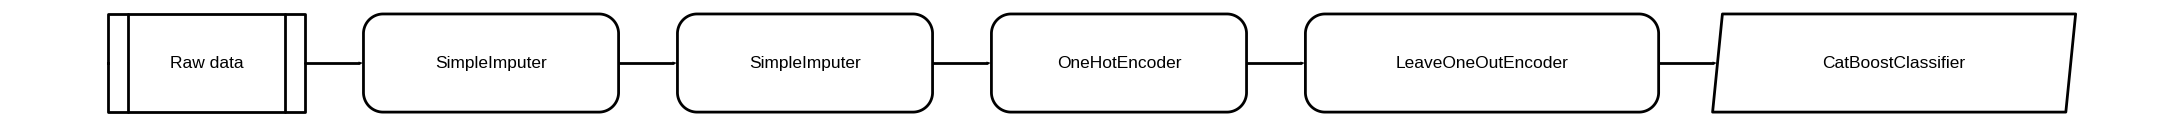

In [13]:
evaluate_model(best)

In [14]:
# functional API
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,CatBoost Classifier,0.9997,1.0000,0.9997,0.9997,0.9997,0.9994,0.9994,0.9854


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,prediction_label,prediction_score
88181,0,tcp,vmnet,S0,0,0,0,0,0,0,...,0.07,0.00,0.00,1.0,1.0,0.00,0.0,1,1,1.0000
88182,0,tcp,link,S0,0,0,0,0,0,0,...,0.07,0.00,0.00,1.0,1.0,0.00,0.0,1,1,1.0000
88183,0,tcp,private,S0,0,0,0,0,0,0,...,0.08,0.00,0.00,1.0,1.0,0.00,0.0,1,1,1.0000
88184,0,udp,domain_u,SF,46,117,0,0,0,0,...,0.01,0.00,0.00,0.0,0.0,0.02,0.0,0,0,1.0000
88185,0,tcp,http,REJ,0,0,0,0,0,0,...,0.00,0.03,0.18,0.0,0.0,1.00,1.0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,http,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.0,0.0,1.00,1.0,1,1,0.9990
125969,0,tcp,http,SF,316,314,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,0,0.9999
125970,0,tcp,bgp,S0,0,0,0,0,0,0,...,0.09,0.00,0.00,1.0,1.0,0.00,0.0,1,1,1.0000
125971,0,tcp,http,SF,220,3358,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,0,1.0000


In [15]:
predictions = predict_model(best, data=df_test_final)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,CatBoost Classifier,0.8175,0.9754,0.8175,0.8542,0.7988,0.7150,0.7357,0.6573


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,prediction_label,prediction_score
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,1,1.0000
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,1,0.9998
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,0,0.9996
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,2,2,0.9996
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,2,0,0.5047


              precision    recall  f1-score   support

      normal       0.72      0.97      0.83      9711
         dos       0.96      0.84      0.90      7458
       probe       0.88      0.79      0.83      2421
         r2l       0.99      0.27      0.42      2754
         u2r       0.92      0.18      0.30       200

    accuracy                           0.82     22544
   macro avg       0.90      0.61      0.66     22544
weighted avg       0.85      0.82      0.80     22544



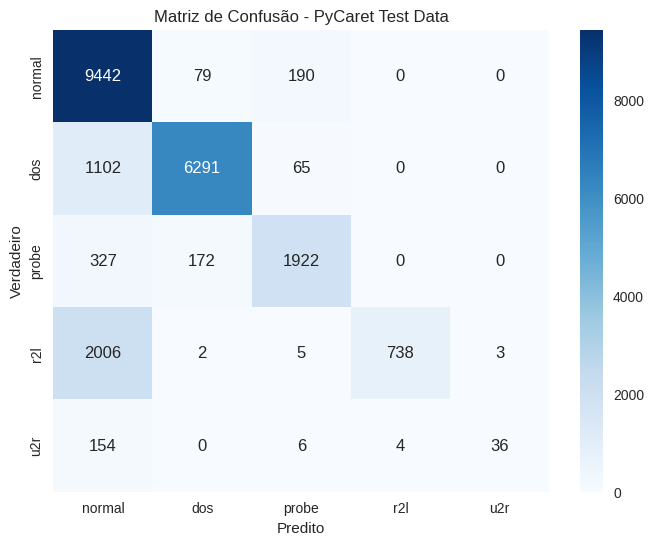

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assumindo que 'label' é a coluna target no df_test_final
y_test = df_test_final['label']

# Assumindo que o predict_model adiciona uma coluna 'prediction_label'
y_pred = predictions['prediction_label']

# Definir os nomes das classes (rótulos)
target_names = ['normal', 'dos', 'probe', 'r2l', 'u2r']


print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - PyCaret Test Data")
plt.show()